In [1]:
import os
if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Synthetic data generation

In [3]:
import warnings
warnings.filterwarnings(action='ignore', message="numpy.dtype size changed")

In [4]:
import pandas as pd

## Load transactions

In [5]:
data = pd.read_csv('data/transactions.csv')
data.head(10)

,Unnamed: 0,trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account,mean_income
0,0,695247,2378,1993-01-01,1,2.0,700.0,700.0,NaN,NaN,NaN,[ 11271.53754941]
1,1,695250,2378,1993-01-22,1,2.0,7268.0,7968.0,NaN,NaN,NaN,[ 11271.53754941]
2,2,695266,2378,1993-01-23,1,2.0,14440.0,22408.0,NaN,NaN,NaN,[ 11271.53754941]
3,3,695262,2378,1993-01-24,1,2.0,49752.0,72160.0,NaN,NaN,NaN,[ 11271.53754941]
4,4,695265,2378,1993-01-26,1,2.0,21899.0,94059.0,NaN,NaN,NaN,[ 11271.53754941]
5,5,695560,2378,1993-01-31,0,3.0,34700.0,59453.7,NaN,NaN,NaN,[ 11271.53754941]
6,6,3608592,2378,1993-01-31,1,NaN,94.7,94153.7,2,NaN,NaN,[ 11271.53754941]
7,7,695272,2378,1993-02-05,1,2.0,30192.0,89645.7,NaN,NaN,NaN,[ 11271.53754941]
8,8,695340,2378,1993-02-07,0,0.0,9612.0,80033.7,4,EF,1222903.0,[ 11271.53754941]
9,9,695270,2378,1993-02-11,1,2.0,31038.0,111071.7,NaN,NaN,NaN,[ 11271.53754941]


## Clean dataset

* Leave target columns only (so far: type, operation, amount)
* Filter NaN values
* Convert columns to appropriate type

In [6]:
data = data[['account_id', 'type', 'operation', 'amount']]
data = data.dropna()
data = data[data['type'] != 'VYBER']
data['account_id'] = data['account_id'].astype(dtype='int32')
id_normalization = {x: n for n, x in enumerate(data['account_id'].unique())}
data['account_id'] = data['account_id'].map(arg=id_normalization)
data['type'] = data['type'].astype(dtype='int')
data['type'] = data['type'].astype(dtype='category')
data['operation'] = data['operation'].astype(dtype='int')
data['operation'] = data['operation'].astype(dtype='category')
data['amount'] = data['amount'].astype(dtype='float32')
data.head(10)

,account_id,type,operation,amount
0,0,1,2,700.0
1,0,1,2,7268.0
2,0,1,2,14440.0
3,0,1,2,49752.0
4,0,1,2,21899.0
5,0,0,3,34700.0
7,0,1,2,30192.0
8,0,0,0,9612.0
9,0,1,2,31038.0
10,0,0,3,25200.0


In [7]:
from sklearn.model_selection import train_test_split

In [8]:
data, test = train_test_split(data, test_size=0.2, random_state=42)

## Train model and synthesized data

In [9]:
from synthesized.core import BasicSynthesizer

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3138-2D31-322D-B531
Expires at: 2018-12-31 00:00:00


In [10]:
with BasicSynthesizer(data=data) as synthesizer:
    synthesizer.learn(data=data, verbose=5000)
    synthesized = synthesizer.synthesize(n=10000)

value types:
account_id continuous-integer
type categorical
operation categorical
amount continuous
5000: 1.86e+08
10000: 9.21e+07
15000: 1.09e+08
20000: 1.22e+08
25000: 1.40e+08
30000: 7.86e+06
35000: 8.06e+06
40000: 6.66e+06
45000: 3.78e+06
50000: 6.67e+06


## Display synthesized data

In [11]:
synthesized.head(5)

,account_id,type,operation,amount
0,372,0,3,6353.769043
1,656,0,0,6234.205566
2,387,0,3,5550.634766
3,2230,1,2,23608.552734
4,521,0,0,5117.371094


In [12]:
data.head(5)

,account_id,type,operation,amount
915723,3198,1,1,32768.0
670839,1902,1,2,1800.0
784950,2448,0,0,9641.0
880239,2979,0,3,6600.0
611740,1675,0,3,25500.0


In [13]:
data = data.astype(synthesized.dtypes)

In [14]:
test = data.astype(synthesized.dtypes)

# Visualization of original and synthetic data

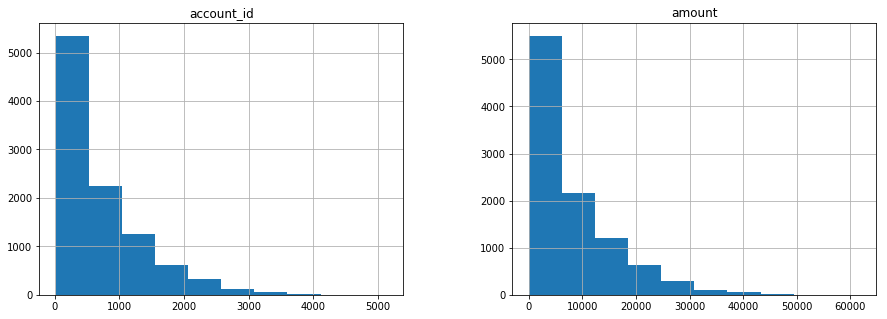

In [15]:
synthesized.hist(figsize=(15,5))
None

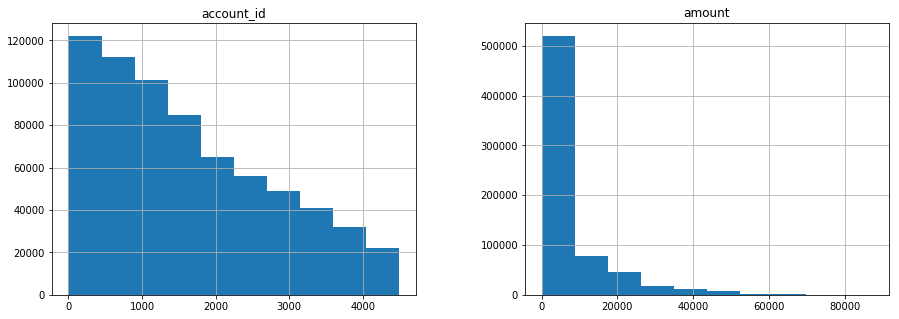

In [16]:
data.hist(figsize=(15,5))
None

# Tests to confirm the utility of synthetic data 

In [19]:
from synthesized.testing import UtilityTesting, ColumnType
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [20]:
testing = UtilityTesting(synthesizer, data, test, synthesized)

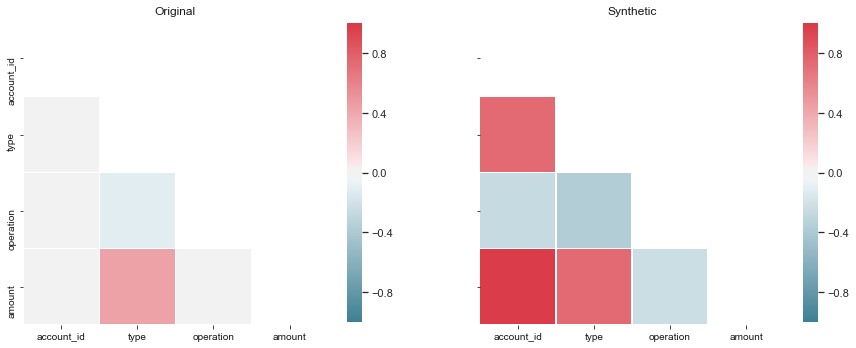

In [21]:
testing.show_corr_matrices()

In [22]:
testing.estimate_utility(classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor())

,target_column,estimator,dummy_original_score,original_score,synth_score,orig_error,synth_error,score_utility,error_utility
0,account_id,DecisionTreeRegressor,9.996459e-11,0.358438,0.000000,938.947206,1747.737836,0.000000,0.537236
1,account_id (categorical reduction),DecisionTreeClassifier,1.782389e-01,0.487833,0.162487,0.512167,0.837562,0.000000,0.611497
2,amount,DecisionTreeRegressor,0.000000e+00,0.549501,0.000000,6776.634858,20329.967599,0.000000,0.333332
3,amount (categorical reduction),DecisionTreeClassifier,7.582629e-01,0.838907,0.298092,0.161093,0.701838,0.000000,0.229530
4,operation,DecisionTreeRegressor,0.000000e+00,0.999029,0.000000,0.039059,1.582618,0.000000,0.024680
5,operation (categorical reduction),DecisionTreeClassifier,4.880610e-01,0.998182,0.558844,0.001818,0.433687,0.138758,0.004193
6,type,DecisionTreeRegressor,0.000000e+00,1.000000,0.000000,0.000000,0.462785,0.000000,0.000000
7,type (categorical reduction),DecisionTreeClassifier,7.405871e-01,1.000000,0.784517,0.000000,0.215976,0.169343,0.000000


In [23]:
testing.compare_marginal_distributions(target_column='operation', conditional_column='amount')

,amount,operation EMD
0,"[0.0, 21825.0)",0.640669
1,"[21825.0, 43650.0)",0.379442
2,"[43650.0, 65475.0)",0.541841
3,"[65475.0, 87300.0)",inf


In [24]:
testing.compare_marginal_distributions(target_column='type', conditional_column='amount', bins=10)

,amount,type EMD
0,"[0.0, 8730.0)",0.000000
1,"[8730.0, 17460.0)",0.011732
2,"[17460.0, 26190.0)",0.181723
3,"[26190.0, 34920.0)",0.308104
4,"[34920.0, 43650.0)",0.000000
5,"[43650.0, 52380.0)",0.000000
6,"[52380.0, 61110.0)",0.000000
7,"[61110.0, 69840.0)",0.562562
8,"[69840.0, 78570.0)",inf
9,"[78570.0, 87300.0)",inf


# Tests to confirm the security of original data 

In [36]:
from synthesized.testing import LinkageAttackTesting, Column

## Focus on a small chunk of original data for demo purposes

In [26]:
data_orig_reduced = data.head(30000)

## Define schema for security checks

Each attribute in a dataset has the following properties to be specified by the user
1. "key_attribute" - whether the attribute can be available to the attacker as background knowledge 
2. "sensitive" - whether the attribute is SPI 
3. "categorical" - wtether the attribute is a categorical variable

In [27]:
schema = {
    'type': Column(key_attribute=False, sensitive=True, categorical=True),
    'operation': Column(key_attribute=True, sensitive=True, categorical=True),
    'amount': Column(key_attribute=True, sensitive=True, categorical=False),
    'account_id': Column(key_attribute=False, sensitive=False, categorical=False),
}

## Identify and demonstrate vulnerabilities in synthetic data

In [28]:
linkage = LinkageAttackTesting(data_orig_reduced, synthesized, schema)

In [29]:
attacks = linkage.identify_attacks()

In [30]:
len(attacks)

2188

In [32]:
linkage.show_attacked_data(attacks[3])

attribute under attack:  operation

bacground knowledge:  amount


 original df subset: 
          account_id type operation  amount
73484           171    0         3    30.0
120253          284    0         3    30.0
539749         1425    0         3    30.0
11690            26    0         3    30.0
911137         3166    0         3    30.0
764169         2339    0         3    30.0
242623          590    0         3    30.0
541120         1429    0         3    30.0
360068          898    0         3    30.0
391445          986    0         3    30.0
26105            59    0         3    30.0
878330         2967    0         3    30.0
1042390        4281    0         3    30.0
332440          823    0         3    30.0
120343          284    0         3    30.0
503325         1311    0         3    30.0
698310         2021    0         3    30.0
1003457        3865    0         3    30.0
169893          406    0         3    30.0
570227         1527    0         3    30.0
511381 

## Clear the synthetic dataset from vulnerabilities

In [33]:
cleared_df = linkage.eradicate_attacks(attacks)

remaining attacks :  2188


C:\Users\Anjei Koziuk\IdeaProjects\synthesized\synthesized\testing\util.py:18: RuntimeWarning:

invalid value encountered in true_divide

C:\Users\Anjei Koziuk\IdeaProjects\synthesized\synthesized\testing\util.py:17: RuntimeWarning:

invalid value encountered in true_divide



## Demonstrate the security of synthetic data

In [37]:
from synthesized.testing.linkage_attack import identify_attacks

In [38]:
new_attacks = identify_attacks(data_orig_reduced, cleared_df, schema)

In [39]:
len(new_attacks)

0

## Demonstrate the utility of synthetic data cleared from all vulnerabilities

In [42]:
testing = UtilityTesting(synthesizer, data, test, cleared_df)

In [43]:
testing.estimate_utility(classifier=DecisionTreeClassifier(), regressor=DecisionTreeRegressor())

,target_column,estimator,dummy_original_score,original_score,synth_score,orig_error,synth_error,score_utility,error_utility
0,account_id,DecisionTreeRegressor,9.996459e-11,0.358438,0.000000,938.947206,1749.335696,0.000000,0.536745
1,account_id (categorical reduction),DecisionTreeClassifier,1.782389e-01,0.487833,0.163247,0.512167,0.836768,0.000000,0.612078
2,amount,DecisionTreeRegressor,0.000000e+00,0.549501,0.000000,6776.634858,20445.719231,0.000000,0.331445
3,amount (categorical reduction),DecisionTreeClassifier,7.582629e-01,0.838907,0.288326,0.161093,0.711718,0.000000,0.226344
4,operation,DecisionTreeRegressor,0.000000e+00,0.999029,0.000000,0.039059,1.633773,0.000000,0.023907
5,operation (categorical reduction),DecisionTreeClassifier,4.880610e-01,0.998182,0.498002,0.001818,0.501878,0.019488,0.003623
6,type,DecisionTreeRegressor,0.000000e+00,1.000000,0.000000,0.000000,0.460251,0.000000,0.000000
7,type (categorical reduction),DecisionTreeClassifier,7.405871e-01,1.000000,0.667464,0.000000,0.316360,0.000000,0.000000


## Demonstrate the synthetic dataset to be released to the user

In [44]:
synthesized

,account_id,type,operation,amount
0,372,0,3,6353.769043
1,656,0,0,6234.205566
2,387,0,3,5550.634766
3,2230,1,2,23608.552734
4,521,0,0,5117.371094
5,114,0,3,660.242737
6,543,1,2,9309.910156
7,84,0,3,775.992126
8,1552,1,2,15534.895508
9,774,0,3,9675.785156
